# Evaluation of RAG Using Ragas

In the following notebook we'll explore how to evaluate RAG pipelines using a powerful open-source tool called "Ragas". This will give us tools to evaluate component-wise metrics, as well as end-to-end metrics about the performance of our RAG pipelines.

In the following notebook we'll complete the following tasks:

The only way to get started is to get started - so let's grab our dependencies for the day!

> NOTE: Using this notebook as presented will incur a charge of ~$3USD from OpenAI usage.

- 🤝 Breakout Room #1
  1. Task 1: Installing Required Libraries
  2. Task 2: Set Environment Variables
  3. Task 3: Creating a Simple RAG Pipeline with LangChain v.0.2.0
  4. Task 4: Synthetic Dataset Generation for Evaluation using Ragas (Optional)

- 🤝 Breakout Room #2
  1. Task 1: Evaluating our Pipeline with Ragas
  2. Task 2: Testing OpenAI's Claim
  3. Task 3: Selecting an Advanced Retriever and Evaluating

> NOTE: This Notebook *does* contain a bonus challenge, outlined at the bottom of the notebook, which you can complete instead of the notebook for full marks on the assignment.

## Motivation

A claim, made by OpenAI, is that their `text-embedding-3-small` is better (generally) than their `text-embedding-ada-002` model.

Here's some passages from their [blog](https://openai.com/blog/new-embedding-models-and-api-updates) about the `text-embedding-3` release:

> `text-embedding-3-small` is our new highly efficient embedding model and provides a significant upgrade over its predecessor, the `text-embedding-ada-002` model...

> **Stronger performance.** Comparing `text-embedding-ada-002` to `text-embedding-3-small`, the average score on a commonly used benchmark for multi-language retrieval ([MIRACL](https://github.com/project-miracl/miracl)) has increased from 31.4% to 44.0%, while the average score on a commonly used benchmark for English tasks ([MTEB](https://github.com/embeddings-benchmark/mteb)) has increased from 61.0% to 62.3%.

Well, with a library like Ragas - we can put that claim to the test!

If what they claim is true - we should see an increase on related metrics by using the new embedding model!

# 🤝 Breakout Room Part #1

## Task 1: Installing Required Libraries

A reminder that one of the [key features](https://python.langchain.com/v0.2/docs/versions/v0_2/) of LangChain v0.2.0 is the compartmentalization of the various LangChain ecosystem packages!

So let's begin grabbing all of our LangChain related packages!

In [1]:
!pip install -U -q langchain langchain-openai langchain_core langchain-community langchainhub openai langchain-qdrant


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


We'll also get the "star of the show" today, which is Ragas!

In [2]:
!pip install -qU ragas


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


We'll be leveraging [QDrant](https://qdrant.tech/) again as our LangChain `VectorStore`.

We'll also install `pymupdf` and its dependencies which will allow us to load PDFs using the `PyMuPDFLoader` in the `langchain-community` package!

In [3]:
!pip install -qU qdrant-client pymupdf pandas


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


## Task 2: Set Environment Variables

Let's set up our OpenAI API key so we can leverage their API later on.

In [4]:
import os
import openai
from getpass import getpass

openai.api_key = getpass("Please provide your OpenAI Key: ")
os.environ["OPENAI_API_KEY"] = openai.api_key

## Task 3: Creating a Simple RAG Pipeline with LangChain v0.2.0

Building on what we've been learning, we'll be leveraging LangChain v0.2.0 and LCEL to build a simple RAG pipeline that we can baseline with Ragas.

## Building our RAG pipeline

Let's review the basic steps of RAG again:

- Create an Index
- Use retrieval to obtain pieces of context from our Index that are similar to our query
- Use a LLM to generate responses based on the retrieved context

Let's get started by creating our index.

> NOTE: We're going to start leaning on the term "index" to refer to our `VectorStore`, `VectorDatabase`, etc. We can think of "index" as the catch-all term, whereas `VectorStore` and the like relate to the specific technologies used to create, store, and interact with the index.

### Creating an Index

You'll notice that the largest changes (outside of some import changes) are that our old favourite chains are back to being bundled in an easily usable abstraction.

We can still create custom chains using LCEL - but we can also be more confident that our pre-packaged chains are creating using LCEL under the hood.

#### Loading Data

Let's start by loading some data!

- [`PyMuPDFLoader`](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.pdf.PyMuPDFLoader.html)

> NOTE: You'll notice that we're using a document loader from the community package of LangChain. This is part of the v0.2.0 changes that make the base (`langchain-core`) package remain lightweight while still providing access to some of the more powerful community integrations.

In [5]:
from langchain_community.document_loaders import PyMuPDFLoader

PDF_LINK = "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf"

### YOUR CODE HERE
loader = PyMuPDFLoader(
    PDF_LINK
)

### YOUR CODE HERE
documents = loader.load()

In [6]:
documents[0].metadata

{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf',
 'page': 0,
 'total_pages': 195,
 'format': 'PDF 1.3',
 'title': 'The Pmarca Blog Archives',
 'author': '',
 'subject': '',
 'keywords': '',
 'creator': '',
 'producer': 'Mac OS X 10.10 Quartz PDFContext',
 'creationDate': "D:20150110020418Z00'00'",
 'modDate': "D:20150110020418Z00'00'",
 'trapped': ''}

#### Transforming Data

Now that we've got our single document - let's split it into smaller pieces so we can more effectively leverage it with our retrieval chain!

We'll start with the classic: `RecursiveCharacterTextSplitter`.

- [`RecursiveCharacterTextSplitter`](https://api.python.langchain.com/en/latest/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain-text-splitters-character-recursivecharactertextsplitter)

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

CHUNK_SIZE = 200
CHUNK_OVERLAP = 50

### YOUR CODE HERE
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,
    chunk_overlap=CHUNK_OVERLAP
)

### YOUR CODE HERE
documents = text_splitter.split_documents(documents)

Let's confirm we've split our document.

In [8]:
len(documents)

1864

#### Loading OpenAI Embeddings Model

We'll need a process by which we can convert our text into vectors that allow us to compare to our query vector.

Let's use OpenAI's `text-embedding-ada-002` for this task!

- [`OpenAIEmbeddings`](https://api.python.langchain.com/en/latest/embeddings/langchain_openai.embeddings.base.OpenAIEmbeddings.html#langchain-openai-embeddings-base-openaiembeddings)

> NOTE: We are purposefully using an older embedding model to try and answer the guiding question: Is TE3 better than Ada-002?

In [9]:
from langchain_openai import OpenAIEmbeddings

EMBEDDING_MODEL = "text-embedding-ada-002"

### YOUR CODE HERE
embeddings = OpenAIEmbeddings(
    model=EMBEDDING_MODEL
)

#### Creating a QDrant VectorStore

Now that we have documents - we'll need a place to store them alongside their embeddings.

- [`Qdrant`](https://api.python.langchain.com/en/latest/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore)

> NOTE: You'll need to provide the embedding dimension for Ada-002!

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

LOCATION = ":memory:"
COLLECTION_NAME = "PMarca Blogs"
VECTOR_SIZE = 1536

In [11]:
### YOUR CODE HERE
qdrant_client = QdrantClient(LOCATION)

qdrant_client.create_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=VectorParams(size=VECTOR_SIZE, distance=Distance.COSINE),
)

### YOUR CODE HERE
qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=OpenAIEmbeddings(),

)

qdrant_vector_store.add_documents(documents)

['fa873d548884463bb83eabe7304efc3e',
 'b587aac010f3429b9682f95392b82f30',
 'cbb714e2a8484b1cb33acaeea987d6e8',
 '75969edc6be24713b1e98e0937a7a1e0',
 '08ff90cadc58441394ecb10ebb3c3159',
 'a46f1a220f4e4300baaa40aa57c99a52',
 'cf9b1d01d2864b0bb966466cd9557003',
 'addfcb4b070f42f69435538ea91c2623',
 '79595c759dc2471d8a79f17338269e59',
 '83978f44a23f4041b5736fdcc88fde64',
 '3d49a31a196d43f0abbcf480a8e0b544',
 '94f40f07ea94434baeaac9a43b9dd50c',
 '0276bd4c3eb144ffb16991ea9651a6f4',
 '436a8415f0874b6fbfaef3fa3563ce1e',
 '663b47ee29444b8791d9b5b0b76b6868',
 '4cd92c0e335847329c2c82d029849f8b',
 'ac1c49d1f7f14ad7a5525cd6d9fadef5',
 '8d4ab435f9f54957bf61fd9fe60cc79c',
 '48ff86a94ebf497a9440dc9eb042ec71',
 '09ae7c1f00764cc2ab268007e5fb6e99',
 '8593222c692b46bca1f0b0a3de1fe0f9',
 '64860ff8f3bf40e185687185997df933',
 '4ce108065dea4ca5a4517af55f3731a5',
 'ba4e966bde3241cab2606c7cab392db5',
 '8b8bf207834b47f7a3ffd2b6a9e9219b',
 '5b54b1f1fdb34022a33fb5370a9b49e5',
 '4c34d27179c047d3a629d671843b9af7',
 

####❓ Question #1:

List out a few of the techniques that Qdrant uses that make it performant.

> NOTE: Check the [documentation](https://qdrant.tech/documentation/overview/) for more information about QDrant!

## ANSWER #1:

1.  Qdrant uses a highly performant technique called HNSW (Hierarchical Navigable Small World) that is used to implement Approximate Nearest Neighbors; this can retrieve the most relevant chunks very quickly.

2.  The idea of using performant *heuristics* like Approximate Nearest Neighbors (ANN) makes vector stores like Qdrant much faster than *exact* searches that would need to be *exhaustive*!

3.  Qdrant uses a technique called Product Quantization (PQ) - this is very different from, and complementary to, dimensionality reduction.  PQ may be thought of as a compression technique that speeds up computations of similarity by orders of magnitude.

4.  Qdrant, like all other vector databases, offers the option of `in-memory` storage for manageable sizes entries.  Holding an entire index in memory can speed up retrieval in these cases.

#### Creating a Retriever

To complete our index, all that's left to do is expose our vectorstore as a retriever - which we can do the same way we would in previous version of LangChain!

In [12]:
### YOUR CODE HERE
retriever = qdrant_vector_store.as_retriever()

#### Testing our Retriever

Now that we've gone through the trouble of creating our retriever - let's see it in action!

In [13]:
retrieved_documents = retriever.invoke("What is a rule of thumb for selecting an industry to invest in?")

In [14]:
for doc in retrieved_documents:
  print(doc)

page_content='the existing order — and make sure that those forces of change
have a reasonable chance at succeeding.
Second rule of thumb:
Once you have picked an industry, get right to the center of it' metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 125, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '59e233c29c6b4640877f11834b345a58', '_collection_name': 'PMarca Blogs'}
page_content='Third rule:
In a rapidly changing Held like technology, the best place to
get experience when you’re starting out is in younger, high-
growth companies.' metadata={'source': 'https://d1lamhf6l6yk6d.cloud

### Creating a RAG Chain

Now that we have the "R" in RAG taken care of - let's look at creating the "AG"!

#### Creating a Prompt Template

There are a few different ways we could create our prompt template - we could create a custom template, as seen in the code below, or we could simply pull a prompt from the prompt hub! Let's look at an example of that!

In [15]:
from langchain import hub

retrieval_qa_prompt = hub.pull("langchain-ai/retrieval-qa-chat")

/Users/vinodchandrashekaran/.virtualenvs/aie4challenge/lib/python3.11/site-packages/langsmith/client.py:312: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
/Users/vinodchandrashekaran/.virtualenvs/aie4challenge/lib/python3.11/site-packages/langsmith/client.py:5515: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  prompt = loads(json.dumps(prompt_object.manifest))


In [16]:
print(retrieval_qa_prompt.messages[0].prompt.template)

Answer any use questions based solely on the context below:

<context>
{context}
</context>


As you can see - the prompt template is simple (and has a small error) - so we'll create our own to be a bit more specific!

In [17]:
from langchain.prompts import ChatPromptTemplate

template = """
Use the provided context to answer the following question.
If you can't answer the question based on the context, say you don't know.

Question:
{question}

Context:
{context}
"""

prompt = ChatPromptTemplate.from_template(template=template)

#### Setting Up our Basic QA Chain

Now we can instantiate our basic RAG chain!

We'll use LCEL directly just to see an example of it - but you could just as easily use an abstraction here to achieve the same goal!

We'll also ensure to pass-through our context - which is critical for RAGAS.

In [18]:
from operator import itemgetter

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

primary_qa_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": prompt | primary_qa_llm, "context": itemgetter("context")}
)

Let's test it out!

In [19]:
question = "What is a rule of thumb for selecting an industry to invest in?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)

A rule of thumb for selecting an industry to invest in is to ensure that you understand the existing order and the forces of change within that industry, and that those forces have a reasonable chance of succeeding. Additionally, once you have picked an industry, it is advised to get right to the center of it, focusing on where the great opportunities can be found.


In [20]:
question = "What did Pink Floyd have to say about how to proceed when investing in a new industry?"

result = retrieval_augmented_qa_chain.invoke({"question" : question})

print(result["response"].content)
print(result["context"])

The context does not provide specific insights or quotes from Pink Floyd regarding how to proceed when investing in a new industry. Therefore, I don't know.
[Document(metadata={'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'page': 15, 'total_pages': 195, 'format': 'PDF 1.3', 'title': 'The Pmarca Blog Archives', 'author': '', 'subject': '', 'keywords': '', 'creator': '', 'producer': 'Mac OS X 10.10 Quartz PDFContext', 'creationDate': "D:20150110020418Z00'00'", 'modDate': "D:20150110020418Z00'00'", 'trapped': '', '_id': '0bcad6507bf741b0a8f8e2e01bc4a362', '_collection_name': 'PMarca Blogs'}, page_content='ask if you can call them again if things change.\nTrust me — they’d much rather be saying “yes” than “no” —\nthey need all the good investments they can get.\nSecond, consider the environment.'), Document(metadata={'source': 'https://d1lamh

We can already see that there are some improvements we could make here.

For now, let's switch gears to RAGAS to see how we can leverage that tool to provide us insight into how our pipeline is performing!

## Task 4: Synthetic Dataset Generation for Evaluation using Ragas

Ragas is a powerful library that lets us evaluate our RAG pipeline by collecting input/output/context triplets and obtaining metrics relating to a number of different aspects of our RAG pipeline.

We'll be evaluating on every core metric today, but in order to do that - we'll need to create a test set. Luckily for us, Ragas can do that directly!

### Synthetic Test Set Generation

We can leverage Ragas' [`Synthetic Test Data generation`](https://docs.ragas.io/en/stable/concepts/testset_generation.html) functionality to generate our own synthetic QC pairs - as well as a synthetic ground truth - quite easily!

In [21]:
loader = PyMuPDFLoader(
    "https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf",
)

eval_documents = loader.load()

text_splitter_eval = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap = 50
)

eval_documents = text_splitter_eval.split_documents(eval_documents)

####❓ Question #2:

Why is it important to split our documents using different parameters when creating our synthetic data?

## ANSWER #2:


============================= ANSWER #2 =================================

As the figure below shows, RAGAS uses the chunks that are created from the documents as the starting point to formulate seed questions and then to evolve them further.

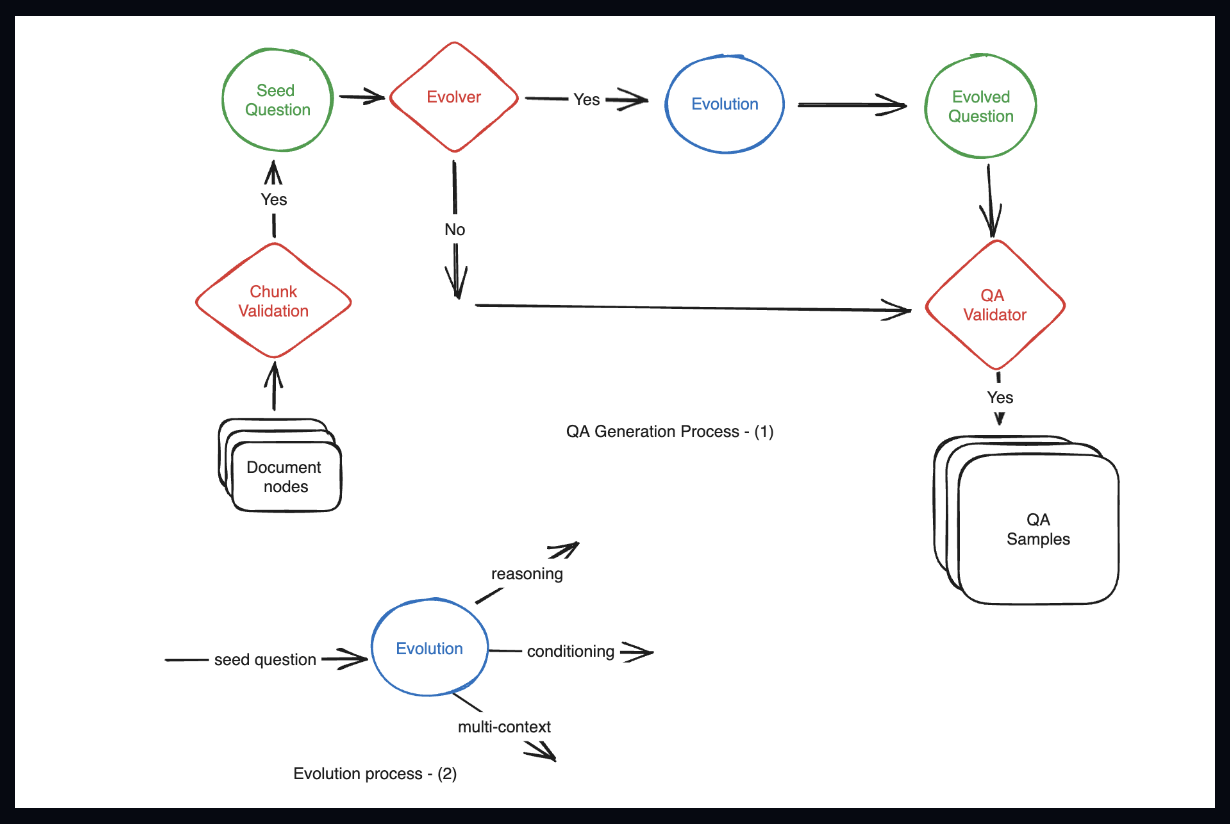


RAGAS evolves the seed question in a few different ways:

1.  Reasoning: Rewrite the question in a way that enhances the need for reasoning to answer it effectively.
2.  Multi-context: Rephrase the question in a manner that requires aggregation of information from multiple sections or chunks to formulate an answer.
3.  Conditioning: Modify the question to add conditioning, which adds complexity to the question.


In order to be able to be effective at formulating more complex questions (reasoning, multi-context, e.g.) it is necessary for the RAGAS pipeline to have as a starting point chunks that are broader and likely already contain multiple pieces of information so that the process of evolving questions from the seed question is more effective.

Hence, it is necessary for us to set up the RAGAS pipeline with documents that are chunked more broadly.



A second reason is that it is necessary to avoid the problem of `overfitting` the SDG process to the same chunks that will be used to test the RAG pipeline.  We want to be able to see if the RAG pipeline we have built is generalizable and the choice of hyperparameters such as the chunk_size and chunk_overlap is one dimension across which we can assess if our pipeline is able to generalize well.  Otherwise, the RAGAS generated evaluation questions may be tuned very well to the chunk_size and chunk_overlap parameters chosen for our actual RAG pipeline.


===================== ANSWER #2 ============================

In [22]:
len(eval_documents)

624

> NOTE: 🛑 Running this cell as presented will incur a charge of ~$3USD from OpenAI usage. Most of this cost is produced by the Synthetic Data Generation step. **YOU CAN SKIP THIS STEP BY LOADING THE `.csv` DIRECTLY FROM OUR REPOSITORY.** 🛑

#### Optional: SDG for Evaluation

## NOTE - I ran the optional cells below !!!

I ran the cell below to see if I run into rate limits.  Thankfully, it ran smoothly!

Time to run the cell: 14mins, 18.4seconds!!!

In [23]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

num_qa_pairs = 20 # You can reduce the number of QA pairs to 5 if you're experiencing rate-limiting issues

testset = generator.generate_with_langchain_docs(eval_documents, num_qa_pairs, distributions)
testset.to_pandas()

/Users/vinodchandrashekaran/.virtualenvs/aie4challenge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Filename and doc_id are the same for all nodes.                     
Generating: 100%|██████████| 20/20 [07:12<00:00, 21.63s/it] 


,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,What factors determine the peak age for creati...,"[ods when productivity is highest, the peak ag...",The factors determining the peak age for creat...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,How can entrepreneurs acquire initial customer...,[This obviously raises the issue of how you’re...,"Try to raise angel money, bootstrap off initia...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,How can undergrads gain real-world working exp...,"[undergrads to do some of the work, and being ...",Undergrads can gain real-world working experie...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,How can blogging about their startup help entr...,[looking for funding to blog — about their sta...,Blogging about their startup can help entrepre...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,What are the consequences of not raising enoug...,[Here’s why you shouldn’t do that:\nWhat are t...,Not raising enough money risks the survival of...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,What should be valued when evaluating candidat...,[How to hire the best people you've\never work...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,What factors contribute to the complexity of d...,"[extreme case, but even a non-extreme version ...",Factors contributing to the complexity of deci...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,What steps can be taken to orchestrate a turna...,[problem — your original product cycle has pea...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,What types of undergraduate degrees are consid...,[workforce in a high-impact way when you gradu...,"Typically, undergraduate degrees that have a t...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,How does the culture of a startup company infl...,"[(In case you were wondering, by the way, the ...",The culture of a startup company influences ho...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


Let's look at the output and see what we can learn about it!

In [24]:
testset.test_data[0]

DataRow(question='What factors determine the peak age for creative impact in individuals?', contexts=['ods when productivity is highest, the peak age for creative impact\nshould not vary as a function of either the success of the particular\ncontribution or the Xnal fame of the creator. …\nThus, even though an impressive lifetime output of works, and\nsubsequent distinction, is tied to precocity, longevity, and produc-\ntion rate, the expected age optimum for quantity and quality of\ncontribution is dependent solely on the particular form of creative\nexpression.\nWow, again.\nAnyone who demonstrates… an age decrement in achievement is\nlikely to provoke controversy. Aaer all, aging is a phenomenon easy'], ground_truth='The factors determining the peak age for creative impact in individuals are not explicitly mentioned in the context provided.', evolution_type='simple', metadata=[{'source': 'https://d1lamhf6l6yk6d.cloudfront.net/uploads/2021/08/The-pmarca-Blog-Archives.pdf', 'file_path

### Load the 'live' generated RAGAS questions to Pandas and save to disk

In [26]:
testset_df = testset.to_pandas()
testset_df.to_csv("testset_from_ragas_run.csv")

#### PREFERRED: Download `.csv` from DataRepository

In [27]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (79/79), done.s:  79% (63/79)
remote: Compressing objects: 100% (66/66), done.
remote: Total 87 (delta 24), reused 28 (delta 8), pack-reused 8 (from 1)
Receiving objects: 100% (87/87), 70.09 MiB | 35.65 MiB/s, done.
Resolving deltas: 100% (24/24), done.


### Copy the Questions downloaded from AIM Repo and save in file

In [28]:
!mv DataRepository/testset.csv ./testset_downloaded_from_repo.csv

### Set name of file to use in the rest of notebook!!!

In [29]:
qa_file_to_use = 'testset_from_ragas_run.csv'

### Generating Responses with RAG Pipeline

Now that we have some QC pairs, and some ground truths, let's evaluate our RAG pipeline using Ragas.

The process is, again, quite straightforward - thanks to Ragas and LangChain!

Let's start by extracting our questions and ground truths from our create testset.

We can start by converting our test dataset into a Pandas DataFrame.

In [30]:
import pandas as pd

test_df = pd.read_csv(qa_file_to_use)

In [31]:
test_df

,Unnamed: 0,question,contexts,ground_truth,evolution_type,metadata,episode_done
0,0,What factors determine the peak age for creati...,"['ods when productivity is highest, the peak a...",The factors determining the peak age for creat...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
1,1,How can entrepreneurs acquire initial customer...,['This obviously raises the issue of how you’r...,"Try to raise angel money, bootstrap off initia...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
2,2,How can undergrads gain real-world working exp...,"['undergrads to do some of the work, and being...",Undergrads can gain real-world working experie...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
3,3,How can blogging about their startup help entr...,['looking for funding to blog — about their st...,Blogging about their startup can help entrepre...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
4,4,What are the consequences of not raising enoug...,['Here’s why you shouldn’t do that:\nWhat are ...,Not raising enough money risks the survival of...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
5,5,What should be valued when evaluating candidat...,"[""How to hire the best people you've\never wor...",The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
6,6,What factors contribute to the complexity of d...,"['extreme case, but even a non-extreme version...",Factors contributing to the complexity of deci...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
7,7,What steps can be taken to orchestrate a turna...,['problem — your original product cycle has pe...,The answer to given question is not present in...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
8,8,What types of undergraduate degrees are consid...,['workforce in a high-impact way when you grad...,"Typically, undergraduate degrees that have a t...",simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True
9,9,How does the culture of a startup company infl...,"['(In case you were wondering, by the way, the...",The culture of a startup company influences ho...,simple,[{'source': 'https://d1lamhf6l6yk6d.cloudfront...,True


In [32]:
test_questions = test_df["question"].values.tolist()
test_groundtruths = test_df["ground_truth"].values.tolist()

Now we'll generate responses using our RAG pipeline using the questions we've generated - we'll also need to collect our retrieved contexts for each question.

We'll do this in a simple loop to see exactly what's happening!

In [33]:
answers = []
contexts = []

for question in test_questions:
  response = retrieval_augmented_qa_chain.invoke({"question" : question})
  answers.append(response["response"].content)
  contexts.append([context.page_content for context in response["context"]])

Now we can wrap our information in a Hugging Face dataset for use in the Ragas library.

In [35]:
from datasets import Dataset

response_dataset = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

Let's take a peek and see what that looks like!

In [36]:
response_dataset[0]

{'question': 'What factors determine the peak age for creative impact in individuals?',
 'answer': "The context suggests that the peak age for creative impact in individuals is influenced by several factors, including:\n\n1. **Productivity Levels**: The creator's most distinguished work tends to appear during periods of highest productivity in their career.\n2. **Total Lifetime Output**: There is a relationship between total lifetime output and the peak age for creative achievement within a single career.\n3. **Intrinsic Factors**: Possible intrinsic factors may explain the relationship between age and creative accomplishment, although specific intrinsic factors are not detailed in the provided context.\n\nAdditionally, the context hints at variations in peak ages across different fields, with some fields exhibiting peak creativity in one's late 20s or early 30s, while others may peak in the late 40s or early 50s.",
 'contexts': ['creator’s most distinguished work will appear in those 

# 🤝 Breakout Room Part #2

## Task 1: Evaluating our Pipeline with Ragas

Now that we have our response dataset - we can finally get into the "meat" of Ragas - evaluation!

First, we'll import the desired metrics, then we can use them to evaluate our created dataset!

Check out the specific metrics we'll be using in the Ragas documentation:

- [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
- [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
- [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
- [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
- [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)

See the accompanied presentation for more in-depth explanations about each of the metrics!

In [37]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    answer_correctness,
    context_recall,
    context_precision,
)

metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
]

All that's left to do is call "evaluate" and away we go!

In [38]:
results = evaluate(response_dataset, metrics)

Evaluating: 100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


In [39]:
results

{'faithfulness': 0.7011, 'answer_relevancy': 0.7863, 'context_recall': 0.7101, 'context_precision': 0.5694, 'answer_correctness': 0.5725}

In [40]:
results_df = results.to_pandas()
results_df

,question,answer,contexts,ground_truth,faithfulness,answer_relevancy,context_recall,context_precision,answer_correctness
0,What factors determine the peak age for creati...,The context suggests that the peak age for cre...,[creator’s most distinguished work will appear...,The factors determining the peak age for creat...,1.000000,0.000000,1.000000,0.000000,0.225571
1,How can entrepreneurs acquire initial customer...,Entrepreneurs can acquire initial customers fo...,[This obviously raises the issue of how you’re...,"Try to raise angel money, bootstrap off initia...",0.714286,1.000000,0.333333,1.000000,0.756554
2,How can undergrads gain real-world working exp...,Undergrads can gain real-world working experie...,[What should I do while I’m in school?\nI’m a ...,Undergrads can gain real-world working experie...,1.000000,0.997880,1.000000,1.000000,0.775597
3,How can blogging about their startup help entr...,Blogging about their startup can help entrepre...,"[esting things going on, about their point of ...",Blogging about their startup can help entrepre...,0.750000,0.983543,1.000000,1.000000,0.546885
4,What are the consequences of not raising enoug...,The consequences of not raising enough money f...,[Here’s why you shouldn’t do that:\nWhat are t...,Not raising enough money risks the survival of...,0.500000,1.000000,0.666667,0.833333,0.552409
5,What should be valued when evaluating candidat...,"When evaluating candidates for a startup, it i...",[priate for your particular startup.\nWith a w...,The answer to given question is not present in...,0.888889,0.967892,1.000000,0.000000,0.179810
6,What factors contribute to the complexity of d...,The complexity of decision-making within big c...,[and all big companies have one; they have to ...,Factors contributing to the complexity of deci...,0.777778,0.986855,0.285714,0.333333,0.709292
7,What steps can be taken to orchestrate a turna...,To orchestrate a turnaround in the product cyc...,[way beyond retention. But I’ll talk about tha...,The answer to given question is not present in...,0.833333,1.000000,1.000000,0.000000,0.175242
8,What types of undergraduate degrees are consid...,Undergraduate degrees that are considered usef...,[Which undergraduate degrees are useful in\nth...,"Typically, undergraduate degrees that have a t...",1.000000,0.956933,1.000000,1.000000,0.612880
9,How does the culture of a startup company infl...,The provided context does not explicitly detai...,"[(In case you were wondering, by the way, the ...",The culture of a startup company influences ho...,0.500000,0.000000,0.000000,0.333333,0.376733


## Task : Testing OpenAI's Claim

Now that we've seen how our retriever can impact the performance of our RAG pipeline - let's see how changing our embedding model impacts performance.

####🏗️ Activity #1:

Please provide markdown, or code comments, to explain which each of the following steps are doing!

### Instantiate Embeddings

Instantiate `te3_embeddings` using embeddings from OpenAI Embeddings `text-embedding-3-small`.

NOTE that we previously used `text-embedding-ada-002` as the embedding to index text chunks.

We are going to use a supposedly more performant embedding model below `text-embedding-3-small` to see if our RAG pipeline shows better performance across different metrics.

In [41]:
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### Index Document Collection

1.  Initialize `qdrant_client` collection with collection name, dimension of each embedding vector (1536, corresponds to the dimension of the `text-embedding-3-small` embedding vector dim), and similarity metric (cosine similarity).

2.  Instantiate `qdrant_vector_store` using qdrant_client, collection name and embeddings.

3.  Populate the vector store by adding the chunked documents to vector store.  This will load the text embedding for each chunk as well as additional metadata into the vector store.

In [42]:
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"TE3",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"TE3",
    embedding=te3_embeddings,
)

qdrant_vector_store.add_documents(documents)

['088271160998458ba61ba90ebcd99819',
 'ba946a805d5b4a50add613305043a22f',
 '9b87a457b8104f4ba4f330d5d514b882',
 '856f96261b5b404e94340fd114b74548',
 'b50ac65025e945f184bc21cf939e1fc3',
 '29a66307598d417689436077aa465566',
 'd3bff473c1614c6d8bb4bc82dd173a43',
 '3fb77d63981f46b4b7ce7b9efd48e02c',
 'b5b831ce59f04d13ab09483e82ba5e1d',
 'f100b79246e1459cb7d847603a6ea1be',
 '3e41bc34dee940e88c20b6ac2b5ed425',
 'b3777f22e8354e3b9934f23a4b2d6fdd',
 'c1bb02fc51014eb89427893bbb608bc9',
 '16eb6a1b366b4553b7a1f5e44fa65c72',
 '9d785c00a98f406cbb3bf15ae45948da',
 'b728d1d5d575418d90cc211d4c8c1739',
 '641eb8fb9ce84a63bd06e50a6dac98de',
 '8475e3504174487e8163c450fd15f27a',
 '278da292664c404292faef248fc723ee',
 '5388ed3b656248a48101ab9e8a985740',
 '26768849ab1a4bf9a81112f8033ed122',
 '7ae0977380bc42e285fa66f642ef28ea',
 'b8f553ef2b7c4689b6dd4f3a8f1f0be6',
 'a1266ca1dddc4336acc6e7f4bbbffee0',
 '63292a4d11724d7f8308e2e50215414b',
 'ff3a2b7c9ca24444aeccd75560134faa',
 '09d197aa81414617a30e0e2b4d035725',
 

### Set up retriever for vector store

Instantiate the retriever to be used to search vector store and retrieve the top-K chunks based on proximity in embedding space between the query and the chunk.

In [43]:
te3_retriever = qdrant_vector_store.as_retriever()

### Set up document chain including LLM and Q&A Prompt

Instantiate a LangChain `document_chain`.

The primary elements of the `document_chain` are the `LLM` (here it is the `primary_qa_llm` that was set up at the start of the notebook) and the `prompt` (here it is the `retrieval_qa_prompt` which was set up at the start of the notebook).

In [44]:
from langchain.chains.combine_documents import create_stuff_documents_chain

document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

### Set Up Retrieval Chain including Document Chain and Retriever

Instantiate the test retrieval chain.

The elements of this chain are the `retriever` (here, `te3_retriever` set up above) and `document_chain` (set up above).

In [45]:
from langchain.chains import create_retrieval_chain

te3_retrieval_chain = create_retrieval_chain(te3_retriever, document_chain)

### Run the Test Questions Through the RAG Pipeline

1.  For each test question, use the retrieval chain `te3_retrieval_chain` to return a `response`.

2.  Append the `answer` from the response to the list of answers.

3.  Append the list of contexts corresponding to this answer to the full list of all retrieved contexts for all answers.

In [46]:
answers = []
contexts = []

for question in test_questions:
  response = te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

### Load Questions, Answers, Contexts and Ground-Truths into a Huggingface Dataset

Load the list of questions, answers, retrieved contexts and the groundtruths generated by Ragas to a Huggingface Dataset object.

In [47]:
te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

### Evaluate the Performance of the RAG pipeline using the test questions - Using the Five Metrics

Evaluate the performance of the RAG pipeline on the test questions.

Each response is evaluated against the five metrics chosen earlier:

`faithfulness`

`answer_relevancy`

`context_recall`

`context_precision`

`answer_correctness`

In [50]:
te3_advanced_retrieval_results = evaluate(te3_response_dataset_advanced_retrieval, metrics)

Evaluating: 100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


In [51]:
te3_advanced_retrieval_results

{'faithfulness': 0.7475, 'answer_relevancy': 0.8763, 'context_recall': 0.6899, 'context_precision': 0.6316, 'answer_correctness': 0.6306}

In [52]:
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])

df_merged = pd.merge(df_baseline, df_comparison, on='Metric')

df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']

df_merged

,Metric,ADA,TE3,Baseline -> TE3
0,faithfulness,0.701088,0.747537,0.046449
1,answer_relevancy,0.786292,0.876339,0.090048
2,context_recall,0.710119,0.689881,-0.020238
3,context_precision,0.569444,0.631579,0.062135
4,answer_correctness,0.572462,0.630563,0.058102


####❓ Question #3:

Do you think, in your opinion, `text-embedding-3-small` is significantly better than `ada`?

=========================== ANSWER #3 ==============================

## ANSWER #3:

NOTE that there are two LLM-affiliated constructs that are simultaneously being tested here.

1.  `RETRIEVAL`: The LLM embeddings that convert the question into a vector and retrieve similar chunks as context from the document vector store.

2.  `GENERATION`: The LLM that reads the question, the retrieved chunks along with the prompt and generates a response.

We are keeping the `generation` LLM the same across both pipelines: `gpt-4o-mini`.  

The difference between the two pipelines is the embedding model used:  `text-embedding-ada-002`  versus `text-embedding-3-small`.

We should therefore expect that metrics that are purely focused on `GENERATION` quality GIVEN THE CONTEXT to be relatively the same across both pipelines.

We should expect metrics that are either purely focused on `RETRIEVAL` quality or on the full RAG pipeline to show improvements when we use a better embedding model that can improve the `RETRIEVAL` performance.

Brief Notes on each metric:
1.  `faithfulness`: measures `generation` performance of the RAG pipeline GIVEN the context.  We should expect the differences here to be small.

2.  `answer_relevancy`: measures the relevancy of the answer given the question.  In other words, even though the context is not explicitly used here, the answer_relevancy will be higher if the retrieval performance is better.  We should therefore expect improved performance along this dimension because this metric indirectly also measures retrieval performance along with generation performance.

3.  `context_recall`: measures whether all claims in the ground-truth answer are present in the retrieved context.  As such, this measure deals with the `RETRIEVAL` part of the pipeline.  And, we should expect this metric to be higher if we use a more performant embedding model.

4.  `context_precision`: this seems like the analog of `mean average precision` or `MAP` that is used to measure search retrieval performance.  It checks if more relevant contexts, i.e., those that have ground-truth-answer relevant information appear higher in the retrieved chunks.  Once again, this measure deals with the `RETRIEVAL` part of the chain.  And we expect it to be higher if we use a better embedding model.

5.  `answer_correctness`: this measure compares the ground-truth answer to the generated answer and scores them on the basis of semantic similarity as well as factual similarity.  Factual similarity is computed using TP (claims present in both answers), FP (claims in the generated answer but not in the ground-truth), and FN (claims in ground-truth but missing in the generated answer).  Semantic similarity is computed using cosine similarity between the vectorized embeddings of the two sets of answers.  Clearly, this measure also depends on retrieval as well as generation performance.  We should expect this measure to be higher.

SUMMARY
--------
Based on the above qualitative descriptions, we expect that the following measures should be higher:
`answer_relevancy`
`context_recall`
`context_precision`
`answer_correctness`

and the following metric should not change:
`faithfulness`

We see that THREE Of the FOUR measures that we expect to increase did in fact go higher, only exception was `context_recall`.

`faithfulness` also rose by a small amount, but that could just be the result of random variation in our runs.

ANSWER
-------
Considering how hard it is to move the needle on tests like these, I would say `text-embedding-3-small` is much better than `ada`.

=========================== END ANSWER #3 ======================================

## Task 5: Selecting an Advanced Retriever and Evaluating

============================== ACTIVITY #2 START ==============================

#### 🏗️ Activity #2

While the changes that occured due to modifying the embedding model were desirable - you're now tasked with improving `context_recall`, or `context_precision` (or both!).

You'll follow these steps:

1. Reason about this list of Advanced Retrieval methods:
  - [Contextual Compression (Reranker)](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/contextual_compression/)
  - [MultiQueryRetriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/MultiQueryRetriever/)
  - [Parent Document Retriever](https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/parent_document_retriever/)
2. Select the method you think will be the most performant.
3. Implement that method.
4. Create a LCEL chain that utlizes the new Retriever method.
5. Evaluate this LCEL and compare to the TE3 results.

> NOTE: We will spend more time in Session 14 diving into advanced retrieval methods, this activity is only to serve as a basic introduction to the idea of component-wise improvements and how they might impact metrics.

## ACTIVITY #2 MY NOTES!!!

Advanced Retrieval Methods
--------------------------
1.  `Contextual Compression (Reranker)`:  This method compresses and/or filters out relevant context information from the chunks that are assessed to be close to the query.  This can be useful in cases where the needed information is spread across multiple large chunks, so compression and/or filtering out the relevant information before passing it back to the LLM could be very useful.

2.  `MultiQueryRetriever`:  This method formulates many different variations of the query to get a larger set of chunks that are close to the set of queries.  And the union of the chunks retrieved potentially contains more relevant chunks that simple screening on the basis of the single user-defined query.

3.  `Parent Document Retriever`:    This method captures two levels of metadata for each chunk.  One is the chunk-level metadata but a second is the parent level info that the chunk is a part of.  When a retrieval process ranks a chunk highly, the engine returns the parent-level chunk, not just the lower-level chunk that scored highly.  The idea is that there is likely to be more information in the parent level chunk that is relevant to the query.

My selected Advanced Retrieval Method
--------------------------------------
Intuitively, I think the `MultiQueryRetriever` is likely to be a good candidate if the goal is to increase `context_recall` or `context_precision` (or both).  This is because the `MultiQueryRetriever` likely casts a wide net based on reformulations of the user-submitted query, and is therefore likely to lead to retrieval of more chunks with relevant information.  Such a process is a necessary ingredient to increase `context_recall` or `context_precision`.


Pipeline Using `MultiQueryRetriever` Implemented Below
-------------------------------------------------------


### NOTE - Collect all relevant steps in RAG pipeline run previously


```python
# define embeddings
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# set up qdrant vectorstore, load docs and index
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"TE3",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)
qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"TE3",
    embedding=te3_embeddings,
)
qdrant_vector_store.add_documents(documents)

# set up chunk retriever
te3_retriever = qdrant_vector_store.as_retriever()

# set up documents chain - prompts plus llm
from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain = create_stuff_documents_chain(primary_qa_llm, retrieval_qa_prompt)

# set up retrieval chain
from langchain.chains import create_retrieval_chain
te3_retrieval_chain = create_retrieval_chain(te3_retriever, document_chain)

# run chain by looping over each question in test list
answers = []
contexts = []
for question in test_questions:
  response = te3_retrieval_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])

# save q, a and c in HF dataset object
te3_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})

# run RAGAS to evaluate the responses using the list of metrics
te3_advanced_retrieval_results = evaluate(te3_response_dataset_advanced_retrieval, metrics)

# print out eval results
te3_advanced_retrieval_results

# compare old and new metrics
df_baseline = pd.DataFrame(list(results.items()), columns=['Metric', 'ADA'])
df_comparison = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])
df_merged = pd.merge(df_baseline, df_comparison, on='Metric')
df_merged['Baseline -> TE3'] = df_merged['TE3'] - df_merged['ADA']
df_merged
```

#### Notes on code below

1.  The steps that will not change from before are:
-   define embeddings
-   set up qdrant vector store, load docs and index
-   set up chunk retriever

2.  At this point in the flow, I will add some changes
-   add a wrapper that i will call `mqretriever` around the base retriever to do `MultiQueryRetriever`

3.  Continue with the steps needed
-   Set up retrieval chain - this time use the `mqretriever`
-   run chain by looping over each question in test list
-   save q, a, and c in HF dataset object
-   run RAGAS eval using stated metrics
-   merge old and new metrics
-   print

In [82]:
# YOUR CODE HERE - #1

# define embeddings
te3_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# set up qdrant vectorstore, load docs and index
qdrant_client.create_collection(
    collection_name=COLLECTION_NAME+"MQX",
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)
mq_qdrant_vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME+"MQX",
    embedding=te3_embeddings,
)
mq_qdrant_vector_store.add_documents(documents)

# set up chunk retriever
mq_retriever = mq_qdrant_vector_store.as_retriever()

In [83]:
# YOUR CODE HERE - #2

## Add wrapper around retriever to do MultiQueryRetriever
from langchain.retrievers.multi_query import MultiQueryRetriever

mq_retriever_from_llm = MultiQueryRetriever.from_llm(
    retriever=mq_retriever, llm=primary_qa_llm
)

In [86]:
# YOUR CODE HERE - #3

# set up LCEL chain using the MultiQuery Retriever
mq_retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("input") | mq_retriever_from_llm, "input": itemgetter("input")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"answer": retrieval_qa_prompt | primary_qa_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [87]:
# YOUR CODE HERE - #4

# run chain by looping over each question in test list
answers = []
contexts = []
for question in test_questions:
  response = mq_retrieval_augmented_qa_chain.invoke({"input" : question})
  answers.append(response["answer"])
  contexts.append([context.page_content for context in response["context"]])


In [88]:
# YOUR CODE HERE - #5

# save q, a and c in HF dataset object
mq_response_dataset_advanced_retrieval = Dataset.from_dict({
    "question" : test_questions,
    "answer" : answers,
    "contexts" : contexts,
    "ground_truth" : test_groundtruths
})


In [89]:

# run RAGAS to evaluate the responses using the list of metrics
mq_advanced_retrieval_results = evaluate(mq_response_dataset_advanced_retrieval, metrics)

# print out eval results
mq_advanced_retrieval_results


Evaluating: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


{'faithfulness': 0.7531, 'answer_relevancy': 0.8813, 'context_recall': 0.7649, 'context_precision': 0.5822, 'answer_correctness': 0.5419}

In [91]:
# YOUR CODE HERE - #6

# compare old and new metrics
df_baseline = pd.DataFrame(list(te3_advanced_retrieval_results.items()), columns=['Metric', 'TE3'])
df_comparison = pd.DataFrame(list(mq_advanced_retrieval_results.items()), columns=['Metric', 'MQ'])
df_merged = pd.merge(df_baseline, df_comparison, on='Metric')
df_merged['Baseline -> MQ'] = df_merged['MQ'] - df_merged['TE3']
df_merged

,Metric,TE3,MQ,Baseline -> MQ
0,faithfulness,0.747537,0.753098,0.005561
1,answer_relevancy,0.876339,0.881259,0.004920
2,context_recall,0.689881,0.764881,0.075000
3,context_precision,0.631579,0.582202,-0.049377
4,answer_correctness,0.630563,0.541917,-0.088646


## ACTIVITY #2 CONCLUSION

From the table above, it seems that as anticipated, the `context_recall` metric does show some improvement with the `MultiQueryRetriever` technique.  However, `context_precision` declines a bit.  

And, somewhat surprisingly, `answer_correctness` declines meaningfully.  

One would need to dig into the source of the decline in `answer_correctness` as the measure weighs both semantic similarity and factual similarity.  

It is plausible that factual similarity stays intact while semantic similarity could change as the context now includes potentially additional chunks and the LLM may well compose a semantically different construct... but this is merely a conjecture...


========================= ACTIVITY #2 END ===================================

## NOTE 1 - I HAVE COMPLETED ALL THE STEPS IN THE ABOVE NOTEBOOK!!!

=====================================================================

## NOTE 2 - I AM ATTEMPTING THE BONUS CHALLENGE FOR MY OWN EDUCATION, NOT FOR GRADE

## ALL WORK FOR THE BONUS CHALLENGE IN A SEPARATE NOTEBOOK AVAILABLE IN THE SAME REPO!!!

#### 🚧 BONUS CHALLENGE 🚧

> NOTE: Completing this challenge will provide full marks on the assignment, regardless of the complete of the notebook. You do not need to complete this in the notebook for full marks.

##### **MINIMUM REQUIREMENTS**:

1. Baseline `LCEL RAG` Application using `NAIVE RETRIEVAL`
2. Baseline Evaluation using `RAGAS METRICS`
  - [Faithfulness](https://docs.ragas.io/en/stable/concepts/metrics/faithfulness.html)
  - [Answer Relevancy](https://docs.ragas.io/en/stable/concepts/metrics/answer_relevance.html)
  - [Context Precision](https://docs.ragas.io/en/stable/concepts/metrics/context_precision.html)
  - [Context Recall](https://docs.ragas.io/en/stable/concepts/metrics/context_recall.html)
  - [Answer Correctness](https://docs.ragas.io/en/stable/concepts/metrics/answer_correctness.html)
3. Implement a `SEMANTIC CHUNKING STRATEGY`.
4. Create an `LCEL RAG` Application using `SEMANTIC CHUNKING` with `NAIVE RETRIEVAL`.
5. Compare and contrast results.

##### **SEMANTIC CHUNKING REQUIREMENTS**:

Chunk semantically similar (based on designed threshold) sentences, and then paragraphs, greedily, up to a maximum chunk size. Minimum chunk size is a single sentence.

Have fun!